# Big Data in Finance: Part IV <BR><BR> Lecture Notes 3: Compustat 
    
**Instructor** <BR>
Kirsten Burr, kburr26@gsb.columbia.edu
    
**TA's:** <BR>
Dian Jiao, dj2526@columbia.edu <BR>
Varuun Deshpande, vdeshpande25@gsb.columbia.edu

<sub> Credit: lecture notes originally developed by Lira Mota

# Compustat

In this section we are going to:
1. Download a set of US firm's annual fundamentals;
2. Understand how the data is organized:
    1. Primary keys;
    2. Secondary keys;
    3. Data frequency;
    4. Others.        
2. Clean the data;
3. Construct important variables:
    1. Book Equity Value
    2. Asset Growth
    3. Operational Profitability

## How is the fundamentals data organized?

* We can display all tables in "comp" library.
* We are going to focus on the "funda" table: annual fundamentals.
* Others that are interesting to know: "namesd"

## Set Up

In [1]:
%matplotlib inline 

#%% Packages 
import wrds
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]

import time
from time import strptime, strftime

# Setups
pd.set_option("display.max_rows", 200) # max number or rows to be displayed 

In [2]:
#%% Set WRDS Connection
db = wrds.Connection(wrds_username='khardnett') # make sure to configure wrds connector before hand.

Loading library list...
Done


### All tables in comp

In [3]:
compm_tables = db.list_tables(library="comp") # compd: Compustat daily update 

In [4]:
 pd.DataFrame({'tables':compm_tables}).head(100) # Transform libs to a Pandas data frame to have a better display.

,tables
0,aco_amda
1,aco_imda
2,aco_indfnta
3,aco_indfntq
4,aco_indfntytd
5,aco_indsta
6,aco_indstq
7,aco_indstytd
8,aco_notesa
9,aco_notesq


### All variables in comp.funda

In [6]:
db.describe_table(library="comp", table="funda")

Approximately 913857 rows in comp.funda.


,name,nullable,type,comment
0,gvkey,True,VARCHAR(6),Global Company Key
1,datadate,True,DATE,Data Date
2,fyear,True,INTEGER,Data Year - Fiscal
3,indfmt,True,VARCHAR(12),Industry Format
4,consol,True,VARCHAR(2),Level of Consolidation - Company Annual Descri...
...,...,...,...,...
943,au,True,VARCHAR(8),Auditor
944,auop,True,VARCHAR(8),Auditor Opinion
945,auopic,True,VARCHAR(1),Auditor Opinion - Internal Control
946,ceoso,True,VARCHAR(1),Chief Executive Officer SOX Certification


#### Where to check variable definitions?
1. [Compustat Data Items](https://wrds-www.wharton.upenn.edu/pages/get-data/compustat-capital-iq-standard-poors/compustat/north-america-daily/fundamentals-annual/)
2. WRDS website: go to the (?) sign
3. What if we want to replicate a paper that says:

   "Earnings (E) is income before extraordinary items (Item 18) plus income statement deferred taxes (Item 50) minus preferred dividends (Item 19), if earnings are positive;" [Baker and Wurgler, JF 2006](https://onlinelibrary.wiley.com/doi/epdf/10.1111/j.1540-6261.2006.00885.x)

    * All previous documentation does not contain ITEM numbers
    * These are the legacy CST item numbers
    * You can find item reference [here](https://www.crsp.org/products/documentation/annual-data-industrial).
    
    

**Objective**

Create a data frame with company fundamentals necessary to replicate FF 2015:

1. Book Equity (BE)
2. Operating Profits (OP)
3. Investment (INV)

# Choose variables of interest

Compustat XpressFeed Variables 1/5:  
* AT      = Total Assets  
* CAPX    = Capital Expenditures  
* CEQ     = Common/Ordinary Equity - Total 
* COGS    = Cost of Goods Sold
* CSHO    = Common Shares Outstanding
* DLC     = Debt in Current Liabilities 
* DLCCH   = Current Debt - Changes
* DLTT    = Long-Term Debt - Total

Compustat XpressFeed Variables 2/5:
* DP      = Depreciation and Amortization
* DVC     = Divdends common/ordinary  
* DVP     = Dividends - Preferred/Preference
* GP      = Gross Profits
* IB      = Income Before Extraordinary Items
* ICAPT   = Invested Capital - Total
* ITCB    = Investment Tax Credit (Balance Sheet)  
* LT      = Total Liabilities

Compustat XpressFeed Variables 3/5:
* MIB     = Minority Interest (Balance Sheet)
* NAICS   = North American Industrial Classification System Variable Name
* NAICSH  = North American Industry Classification Codes - Historical Company Variable Name
* NI      = Net Income
* PPEGT   = "Property, Plant and Equipment - Total (Gross)"
* PRBA    = Postretirement Benefit Assets (from separate pension annual file) 
* PRSTKCC = Purchase of Common Stock (Cash Flow)                   
* PSTKRV  = Preferred Stock Redemption Value

Compustat XpressFeed Variables 4/5:
* PSTK    = Preferred/Preference Stock (Capital) - Total (kd: = par?)               
* PSTKL   = Preferred Stock Liquidating Value     
* PSTKRV  = Preferred Stock Liquidating Value          
* RE      = Retained Earnings
* REVT    = Revenue - Total
* SALE    = Sales/Turnover Net
* SEQ     = Shareholders Equity   
* SIC     = Standard Industrial Classification Code

Compustat XpressFeed Variables 5/5:
* TXDB    = Deferred Taxes Balance Sheet
* TXDI    = Income Taxes - Deferred
* TXDITC  = Deferred Taxes and Investment Tax Credit                        
* WCAPCH  = Working Capital Change - Total
* XINT    = Interest and Related Expense - Total 
* XLR     = Staff Expense - Total
* XRD     = Research and Development Expense 
* XSGAQ   = Selling, General and Administrative Expenses (millions)  

# Download Compustat FUNDA

In [7]:
fund_table = 'funda'

varlist = ['conm', 'tic', 'cusip','fyear', 'fyr', 'at','capx', 'ceq', 'cogs', 'csho', 'dlc', 'dlcch','dltt', 'dp', 'ib', 'itcb', 
           'lt', 'mib', 'naicsh', 'ni', 'prstkcc', 'pstk', 'pstkl', 'pstkrv', 're', 'revt', 'sale', 
           'seq', 'sich', 'txdb', 'txdi', 'txditc', 'wcapch', 'xint', 'xlr', 'xrd', 'xsga']


query = """SELECT gvkey, datadate, {}
           FROM comp.{}
           WHERE datafmt = 'STD'
           AND popsrc = 'D'
           AND indfmt = 'INDL'
           AND consol = 'C'
           AND fyear>=1980;""".format(", ".join(varlist), fund_table)

compa = db.raw_sql(query, date_cols=['datadate'])

del(fund_table, varlist, query)

Always look at your data

In [8]:
# Gerneral Look
compa.head()  

,gvkey,datadate,conm,tic,cusip,fyear,fyr,at,capx,ceq,...,seq,sich,txdb,txdi,txditc,wcapch,xint,xlr,xrd,xsga
0,001001,1980-12-31,A & M FOOD SERVICES INC,AMFD.,000165100,1980,12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,001001,1981-12-31,A & M FOOD SERVICES INC,AMFD.,000165100,1981,12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,001001,1982-12-31,A & M FOOD SERVICES INC,AMFD.,000165100,1982,12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,001003,1983-12-31,A.A. IMPORTING CO INC,ANTQ,000354100,1983,12,8.529,0.146,6.095,...,6.095,NaN,0.0,0.000,0.0,NaN,0.130,NaN,NaN,3.186
4,001001,1983-12-31,A & M FOOD SERVICES INC,AMFD.,000165100,1983,12,14.080,3.367,7.823,...,7.823,NaN,0.0,0.144,0.0,3.618,0.763,NaN,0.0,16.435


In [9]:
# Have a sense about missings
compa['at'].isnull().mean()*100

18.135197942081696

In [10]:
compa.gvkey.nunique()

42908

In [11]:
compa.groupby('fyear').gvkey.nunique()

fyear
1980     6889
1981     7058
1982     7685
1983     7996
1984     8243
1985     8599
1986     9017
1987     9225
1988     9333
1989     9343
1990     9571
1991     9966
1992    10705
1993    11482
1994    11899
1995    12492
1996    12624
1997    12437
1998    12554
1999    12531
2000    12093
2001    11583
2002    11252
2003    11066
2004    10900
2005    10856
2006    10877
2007    10874
2008    10687
2009    10642
2010    10861
2011    11267
2012    11668
2013    11715
2014    11586
2015    11488
2016    11368
2017    11289
2018    11374
2019    11627
2020    11930
2021    12258
2022    12436
2023    12270
2024     9189
Name: gvkey, dtype: int64

# Data Consistency 

## Primary Keys


* We are looking at Annual data
* Logic says that that we should have one company (gvkey) per year (fyear)
* But remember, the primary key for funda is (gvkey and datadate)
* Question: Can a firm have two datadate for the same year?


In [12]:
# It is always good to check if we have the right PK
compa.duplicated(['gvkey', 'datadate']).sum()

0

In [13]:
# Is (gvkey, fyear) PK?
compa[compa.duplicated(['gvkey', 'fyear'])]

,gvkey,datadate,conm,tic,cusip,fyear,fyr,at,capx,ceq,...,seq,sich,txdb,txdi,txditc,wcapch,xint,xlr,xrd,xsga
67648,006557,1982-12-31,LAIDLAW INTERNATIONAL INC,LI.3,50730R102,1982,12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67650,006557,1983-12-31,LAIDLAW INTERNATIONAL INC,LI.3,50730R102,1983,12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
309651,039310,2021-01-31,VICTORIAS SECRET AND CO,VSCO,926400102,2020,1,4229.0,127.0,891.0,...,891.0,5621.0,19.0,-64.0,19.0,NaN,6.0,NaN,0.0,1621.0
354602,066552,2010-12-31,LIMITLESS X HOLDINGS INC,LIMX,090622309,2010,12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
354604,066552,2011-12-31,LIMITLESS X HOLDINGS INC,LIMX,090622309,2011,12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
354606,066552,2012-12-31,LIMITLESS X HOLDINGS INC,LIMX,090622309,2012,12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
354608,066552,2013-12-31,LIMITLESS X HOLDINGS INC,LIMX,090622309,2013,12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
354610,066552,2014-12-31,LIMITLESS X HOLDINGS INC,LIMX,090622309,2014,12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
354612,066552,2015-12-31,LIMITLESS X HOLDINGS INC,LIMX,090622309,2015,12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
354614,066552,2016-12-31,LIMITLESS X HOLDINGS INC,LIMX,090622309,2016,12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Example of a company that have two reports for the same year
compa.loc[compa.gvkey=='006557',['gvkey','datadate','fyear','fyr','conm', 'at']]

,gvkey,datadate,fyear,fyr,conm,at
67645,006557,1980-08-31,1980,8,LAIDLAW INTERNATIONAL INC,201.266
67646,006557,1981-08-31,1981,8,LAIDLAW INTERNATIONAL INC,242.081
67647,006557,1982-08-31,1982,8,LAIDLAW INTERNATIONAL INC,251.360
67648,006557,1982-12-31,1982,12,LAIDLAW INTERNATIONAL INC,NaN
67649,006557,1983-08-31,1983,8,LAIDLAW INTERNATIONAL INC,328.891
67650,006557,1983-12-31,1983,12,LAIDLAW INTERNATIONAL INC,NaN
67651,006557,1984-08-31,1984,8,LAIDLAW INTERNATIONAL INC,426.880
67652,006557,1985-08-31,1985,8,LAIDLAW INTERNATIONAL INC,652.477
67653,006557,1986-08-31,1986,8,LAIDLAW INTERNATIONAL INC,901.769
67654,006557,1987-08-31,1987,8,LAIDLAW INTERNATIONAL INC,1655.019


In [15]:
# How to deal with duplicates? Keep last available entry (datadate)
compa.dropna(subset=['fyear'], inplace=True)
compa.sort_values(['gvkey','fyear','at'], inplace=True)
compa = compa[~compa.duplicated(['gvkey', 'fyear'], keep='first')]

In [16]:
# Always check your result
compa.duplicated(['gvkey', 'fyear']).sum()

0

# Calculate Variables of Interest

## Book Equity

Daniel, Mota, Rottke, Santos (RFS, 2020) BE definition:

Stockholders book equity, minus the book value of preferred stock, plus balance sheet deferred taxes (if available and fiscal year is < 1993), minus investment tax credit (if available), minus post-retirement benefit assets (PRBA) if available. 

Stockholders book equity is shareholder equity (SEQ), common equity (CEQ) plus preferred stock (PSTK) or total
assets (AT) minus liabilities (LT) plus minority interest (MIB, if available) (depending on availability, in that order). 

Book value of preferred stock is redemption (PSTKRV), liquidation (PSTKL), or par value (PSTK) (depending on availability, in that order). 

Deferred taxes is deferred taxes and investment tax credit (TXDITC) or deferred taxes and investment tax credit (TXDB) plus investment tax credit (ITCB) (depending on availability, in that order).


In [18]:
# Calculating BE
# Shareholder Equity
compa['se'] = compa['seq']

# Uses Common Equity (ceq) + Preferred Stock (pstk) if SEQ is missing:
compa['se'] = compa['se'].fillna(compa['ceq'] + compa['pstk'])

# Uses Total Assets (at) - Liabilities (lt) + Minority Interest (mib, if available), if others are missing
compa['se'] = compa['se'].fillna(compa['at'] - compa['lt'] + compa['mib'].fillna(0))
  

In [19]:
# Preferred Stock
# Preferred Stock (Redemption Value)
compa['ps'] = compa['pstkrv']
# Uses Preferred Stock (Liquidating Value (pstkl)) if Preferred Stock (Redemption Value) is missing
compa['ps'] = compa['ps'].fillna(compa['pstkl'])
# Uses Preferred Stock (Carrying Value (pstk)) if others are missing
compa['ps'] = compa['ps'].fillna(compa['pstk'])

In [20]:
# Deferred Taxes
# Uses Deferred Taxes and Investment Tax Credit (txditc)
compa['dt'] = compa['txditc']

# This was Novy-Marx old legacy code. We drop this part to be in accordance with Ken French.
# Uses Deferred Taxes and Investment Tax Credit(txdb) + Investment Tax Credit (Balance Sheet) (itcb) if txditc is missing
compa['dt'] = compa['dt'].fillna(compa['txdb'].fillna(0) + compa['itcb'].fillna(0))
# If all measures are missing, set n  to missing
compa.loc[pd.isnull(compa['txditc']) & pd.isnull(compa['txdb']) & pd.isnull(compa['itcb']), 'dt'] = np.nan

compa.loc[compa['fyear'] >= 1993, 'dt'] = 0

In [21]:
# Book Equity
# Book Equity (BE) = Share Equity (se) - Prefered Stocks (ps) + Deferred Taxes (dt)
compa['be'] = (compa['se']  # shareholder equity must be available, otherwise BE is missing
               - compa['ps']  # preferred stock must be available, otherwise BE is missing
               + compa['dt'].fillna(0))  # add deferred taxes if available
               #- compa['prba'].fillna(0))  # subtract postretirement benefit assets if available

**Always look at your data...**

In [22]:
# Missings
compa.be.isnull().mean()  

0.1830531995319021

<Axes: >

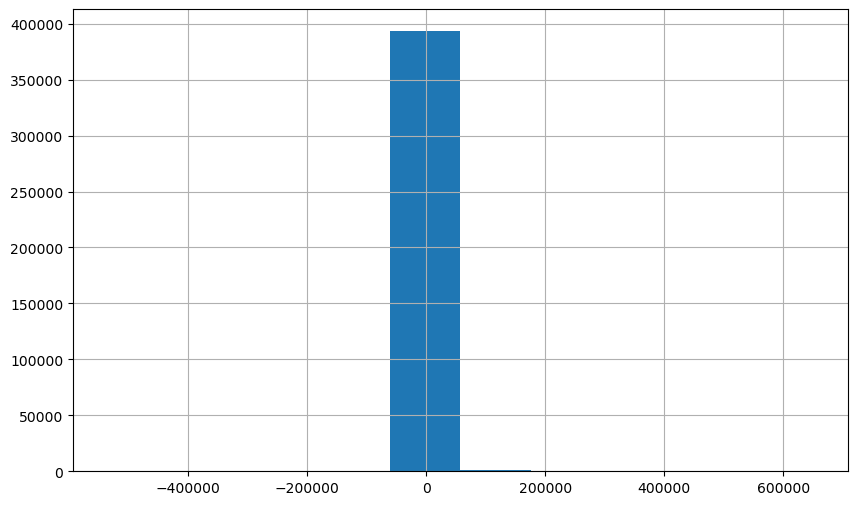

In [23]:
compa.be.hist() 

In [24]:
# Does it make sense to have a negative BE?
(compa.be<0).mean()   

0.09606569940245026

<Axes: >

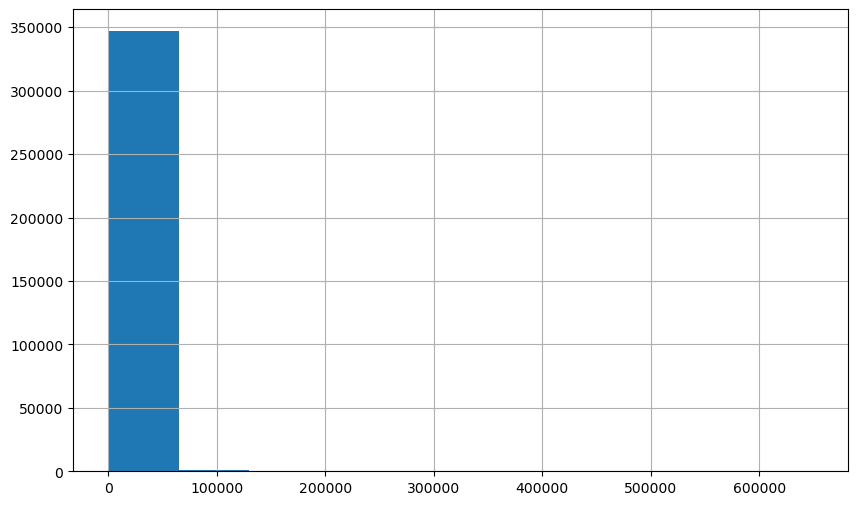

In [25]:
compa[compa.be>0].be.hist()

<Axes: >

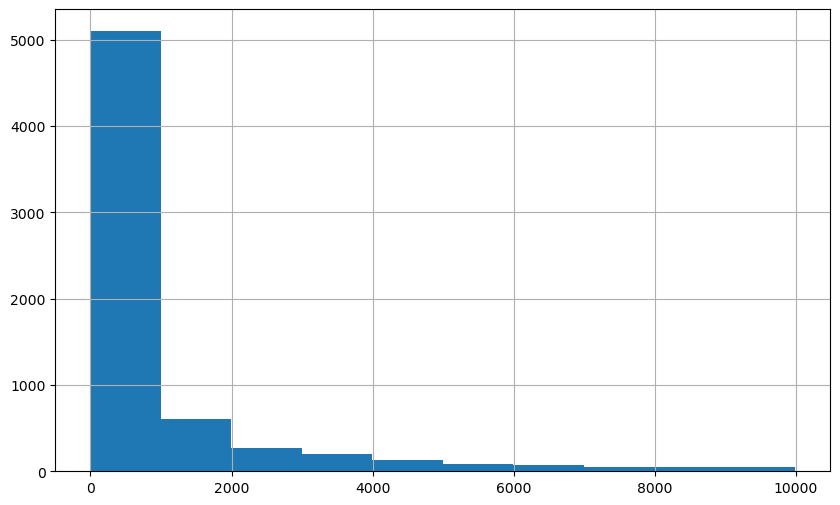

In [26]:
compa[(compa.be>0)&(compa.be<10e3)&(compa.fyear==2017)].be.hist()

## Operating Profitability (OPBE)

Daniel, Mota, Rottke, Santos (RFS, 2020) OPBE definition:

Operating profits to book equity (BE) ratio. 

Operating profits is sales (SALE) minus cost of goods sold (COGS), minus selling, general, and administrative expenses (XSGA),
minus interest expense (XINT). In order to be non-missing, SALE must be non-missing, at least one of the other entries must be non-missing and BE must be greater than zero.

In [27]:
# COST = COGS + XSGA + XINT 
compa['cost'] = compa[['cogs', 'xsga', 'xint']].sum(axis=1, skipna=True)
compa.loc[compa[['cogs', 'xsga', 'xint']].isnull().all(axis=1), 'cost'] = np.nan

In [28]:
# OP = SALE -COST    
compa['op'] = compa['sale']-compa['cost']

**Always look at your data...**

In [29]:
# Look at missings
compa.op.isnull().mean()

0.18682076614782367

<Axes: >

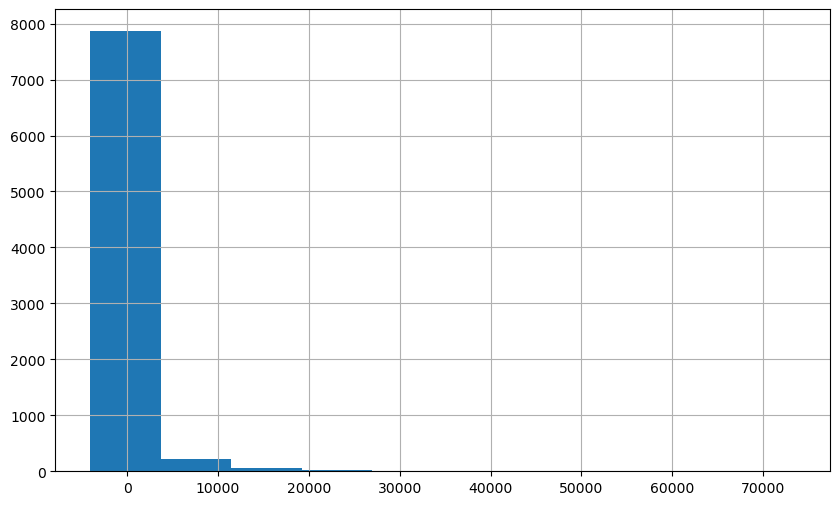

In [30]:
compa[compa.fyear==2017].op.hist()

In [42]:
# Which was the most profitable company in 2023?
compa.loc[compa[compa.fyear==2023].op.idxmax(),['gvkey','conm','op','be','at']]

gvkey                002176
conm     BERKSHIRE HATHAWAY
op                 129379.0
be                 561273.0
at                1069978.0
Name: 14644, dtype: object

<Axes: title={'center': "Apple's OP"}, xlabel='fyear'>

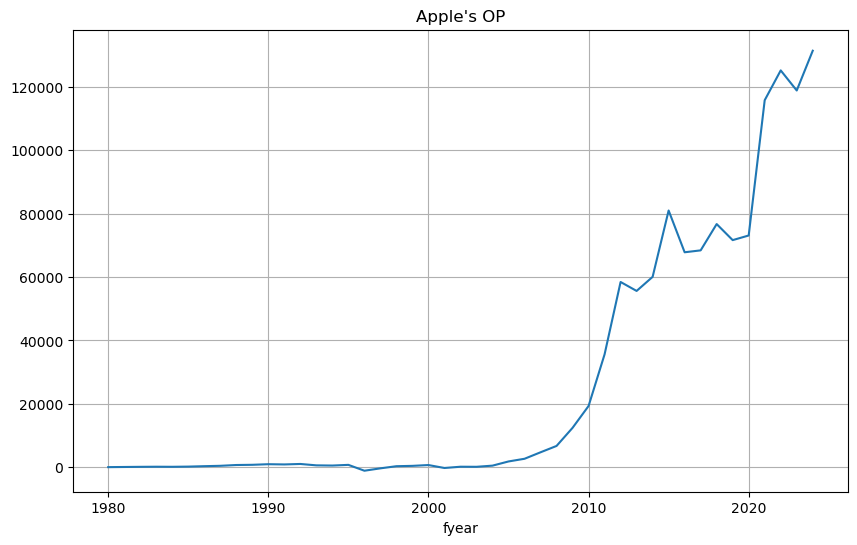

In [44]:
# Plot
compa[compa.gvkey=='001690'].set_index('fyear').op.plot(title = "Apple's OP", grid=True)

In [45]:
# Calculate OPBE
compa.loc[(compa.be > 0), 'opbe'] = compa['op']/compa['be']

**What do we do now?**

Look at the data...

In [46]:
# Look at missings
compa.opbe.isnull().mean()

0.28445231511686914

<Axes: >

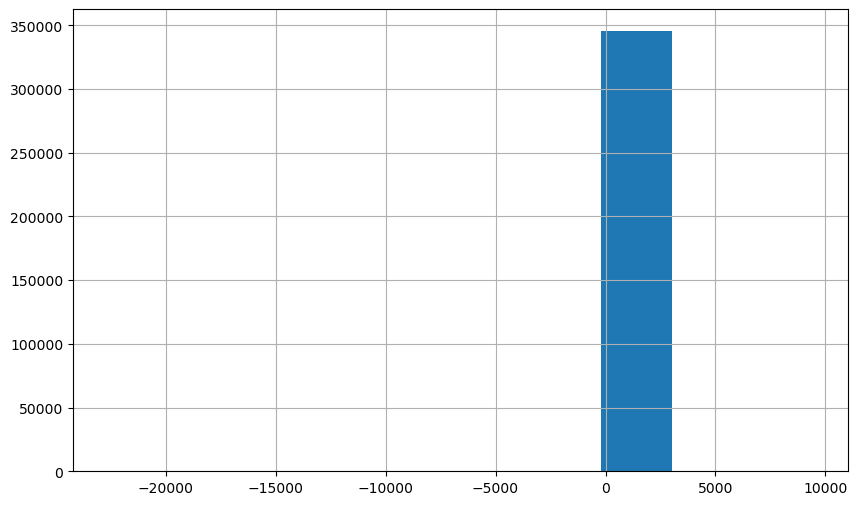

In [47]:
# Be careful with ratios
compa.opbe.hist()

<Axes: title={'center': "Apple's OPBE"}, xlabel='fyear'>

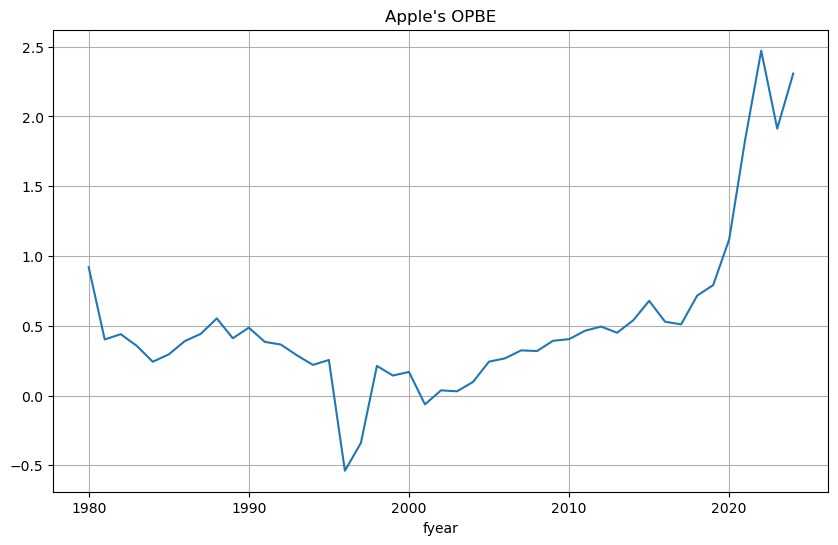

In [48]:
# Plot
compa[compa.gvkey=='001690'].set_index('fyear').opbe.plot(title = "Apple's OPBE", grid=True)

<Axes: xlabel='fyear'>

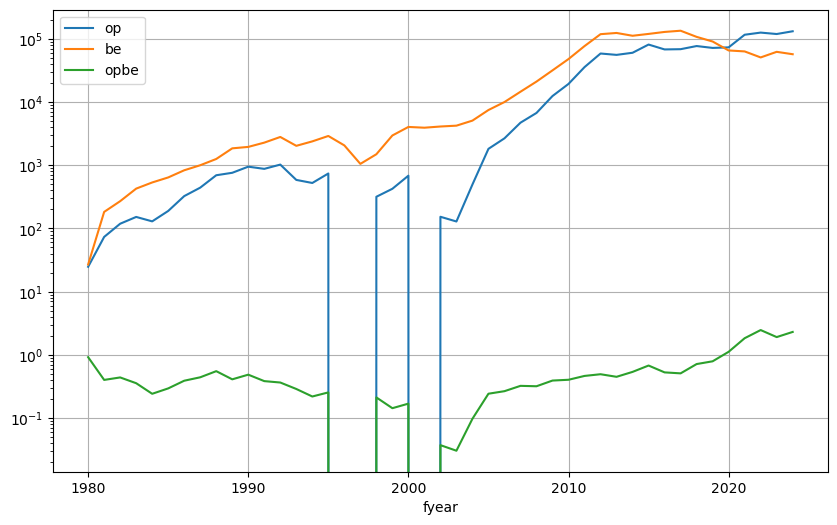

In [49]:
# plot op, be, and op/be on log scale and see difference
compa[compa.gvkey=='001690'].set_index('fyear')[['op', 'be', 'opbe']].plot(label = ["Apple's OPBE"], grid=True, logy=True)

## Investment (INV)

Daniel, Mota, Rottke, Santos (RFS, 2020) INV definition:

Total asset (AT) growth $(AT_t/AT_{t-1} - 1)$. 

We consider PERMCO as company's identification key. AT must be greater than zero to be not missing.


In [50]:
# Calculate lag assets and investment
compa.sort_values(['gvkey', 'fyear'], inplace=True)
compa['at_lag'] = compa.groupby('gvkey').at.shift(1)
compa['inv'] = (compa['at'] - compa['at_lag']) / compa['at_lag']

In [51]:
compa.loc[compa.at_lag==0, 'inv'] = np.nan

What if compa has missing years?

In [52]:
compa['fdiff'] = compa.groupby('gvkey').fyear.diff()

In [53]:
compa[(compa.fdiff>1)][['gvkey','fyear','fdiff', 'at','at_lag', 'inv']]

,gvkey,fyear,fdiff,at,at_lag,inv
22196,002820,2001,4.0,117.090,NaN,NaN
28212,003279,2011,19.0,NaN,1.269,NaN
30367,003469,2002,4.0,406.677,NaN,NaN
34312,003819,2011,19.0,NaN,2.295,NaN
37041,004049,2000,4.0,905.890,NaN,NaN
40309,004292,2012,3.0,0.704,0.534,0.318352
40874,004341,2000,2.0,0.000,NaN,NaN
41657,004412,2004,2.0,213.432,218.681,-0.024003
41660,004412,2008,2.0,219.640,203.755,0.077961
45394,004707,1996,3.0,14.416,NaN,NaN


In [54]:
# Check one case of skipping years
compa.loc[compa.gvkey=='005681',['gvkey','fyear','at','at_lag','inv','fdiff']]  

,gvkey,fyear,at,at_lag,inv,fdiff
56636,005681,1983,6803.074,NaN,NaN,NaN
56637,005681,1984,8885.500,6803.074,0.306101,1.0
56638,005681,1985,10018.598,8885.500,0.127522,1.0
56639,005681,1986,12074.598,10018.598,0.205218,1.0
56640,005681,1987,14109.098,12074.598,0.168494,1.0
56641,005681,1988,17008.699,14109.098,0.205513,1.0
56642,005681,1989,17766.699,17008.699,0.044565,1.0
56643,005681,1990,18259.500,17766.699,0.027737,1.0
56644,005681,1991,13885.098,18259.500,-0.239569,1.0
56645,005681,1995,26.851,13885.098,-0.998066,4.0


In [55]:
# Input missings
filter_inv = (compa['at']<=0)|(compa['at_lag']<=0)|(compa.fdiff>1)
compa.loc[filter_inv,['inv']] = np.nan
del(filter_inv)

In [56]:
# Check one case of skipping years (again)
compa.loc[compa.gvkey=='005681',['gvkey','fyear','at','at_lag','inv']]

,gvkey,fyear,at,at_lag,inv
56636,005681,1983,6803.074,NaN,NaN
56637,005681,1984,8885.500,6803.074,0.306101
56638,005681,1985,10018.598,8885.500,0.127522
56639,005681,1986,12074.598,10018.598,0.205218
56640,005681,1987,14109.098,12074.598,0.168494
56641,005681,1988,17008.699,14109.098,0.205513
56642,005681,1989,17766.699,17008.699,0.044565
56643,005681,1990,18259.500,17766.699,0.027737
56644,005681,1991,13885.098,18259.500,-0.239569
56645,005681,1995,26.851,13885.098,NaN


**What do we do now?**

In [57]:
# Look at missings
compa.inv.isnull().mean()

0.2579302202752664

In [58]:
compa.inv.max()

11492999.0

In [59]:
compa.inv.min()

-0.9999992483516351

In [60]:
# Be careful with ratios
compa.loc[compa.inv.idxmax(axis=0),['gvkey','conm','fyear','at','at_lag','inv']]

gvkey                          039128
conm      BROOKFIELD WEALTH SOLUTIONS
fyear                            2021
at                            11493.0
at_lag                          0.001
inv                        11492999.0
Name: 309153, dtype: object

<Axes: >

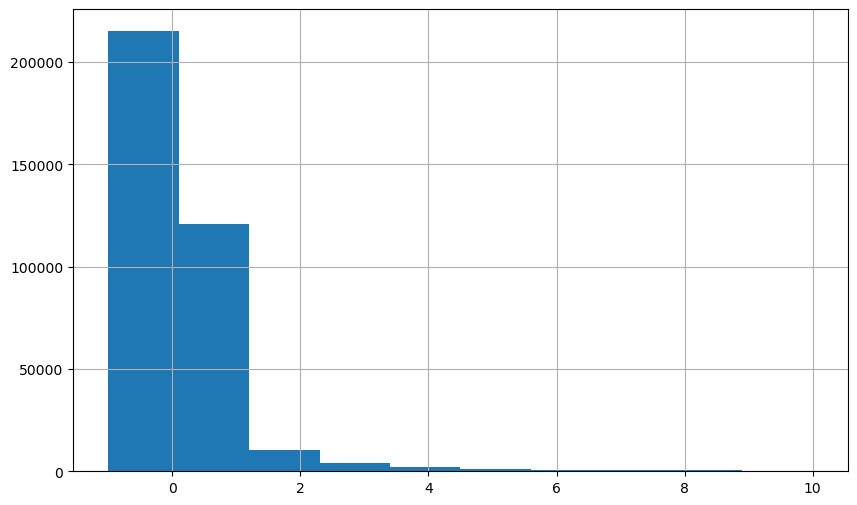

In [61]:
 # What explains such large inv?
compa[compa.inv<10].inv.hist() 

# Is Asset Growth Investment?

* See Cooper, Gulen, Schill, JF (2008);
* What is asset growth capturing other than investment? 
    * Mergers;
    * Issuance;
    * Spin-offs.
* Is it really investments that forecast future stock returns?

In [62]:
# A more traditional measure of investment: CAPX
compa['inv_capx'] = compa['capx']/compa['at_lag']
filter_inv_capx = (compa['capx']<=0)|(compa['at_lag']<=0)|(compa.fdiff>1)
compa.loc[filter_inv_capx,'inv_capx']=np.nan

<Axes: title={'center': "Apple's Investment"}, xlabel='fyear'>

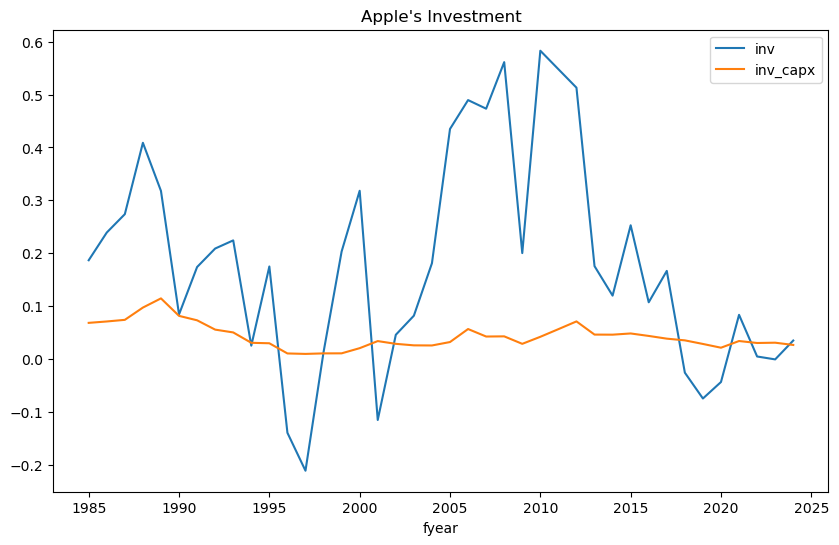

In [63]:
# Difference for Apple
compa.loc[(compa.gvkey=='001690')&
          (compa.fyear>=1985),['fyear','inv','inv_capx']
         ].set_index(['fyear']).plot(title="Apple's Investment") 

<Axes: title={'center': "Apple's Investment"}, xlabel='fyear'>

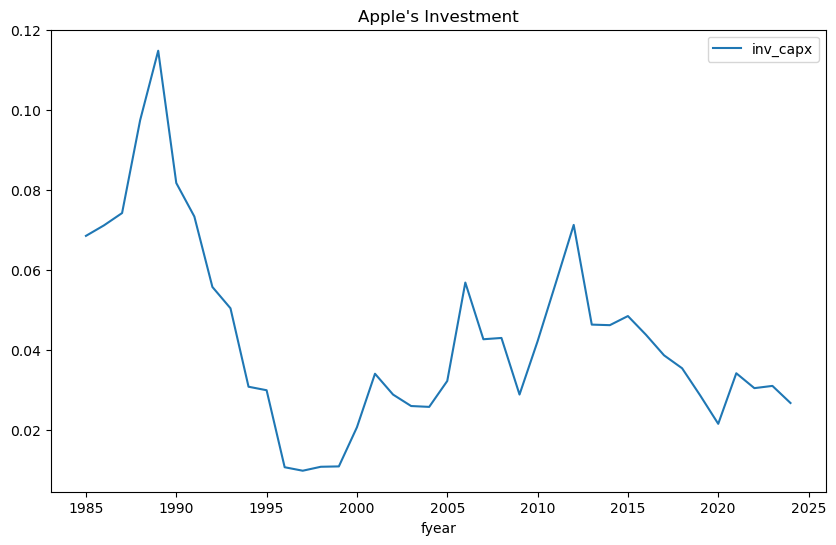

In [64]:
compa.loc[(compa.gvkey=='001690')&
          (compa.fyear>=1985),
          ['fyear','inv_capx']
         ].set_index(['fyear']).plot(title="Apple's Investment")

# Save Output

In [65]:
compa.columns

Index(['gvkey', 'datadate', 'conm', 'tic', 'cusip', 'fyear', 'fyr', 'at',
       'capx', 'ceq', 'cogs', 'csho', 'dlc', 'dlcch', 'dltt', 'dp', 'ib',
       'itcb', 'lt', 'mib', 'naicsh', 'ni', 'prstkcc', 'pstk', 'pstkl',
       'pstkrv', 're', 'revt', 'sale', 'seq', 'sich', 'txdb', 'txdi', 'txditc',
       'wcapch', 'xint', 'xlr', 'xrd', 'xsga', 'se', 'ps', 'dt', 'be', 'cost',
       'op', 'opbe', 'at_lag', 'inv', 'fdiff', 'inv_capx'],
      dtype='object')

In [66]:
compa.to_pickle(path='./compa_annual.pkl')